In [1]:
# Import libraries
import argparse
import os
import random

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from tqdm import tqdm

from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from torchvision.utils import save_image

from pope_loader import POPEDataSet
from minigpt4.common.dist_utils import get_rank
from minigpt4.models import load_preprocess

from minigpt4.common.config import Config
from minigpt4.common.dist_utils import get_rank
from minigpt4.common.registry import registry

# imports modules for registration
from minigpt4.datasets.builders import *
from minigpt4.models import *
from minigpt4.processors import *
from minigpt4.runners import *
from minigpt4.tasks import *

from PIL import Image
from torchvision.utils import save_image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import json

/home/ec2-user/miniconda3/envs/opera_op/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ec2-user/miniconda3/envs/opera_op/lib/python3.10/site-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/ec2-user/miniconda3/envs/opera_op/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/ec2-user/miniconda3/envs/opera_op/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.mod

In [2]:
# Define Model
MODEL_EVAL_CONFIG_PATH = {
    "minigpt4": "eval_configs/minigpt4_eval.yaml",
    "instructblip": "eval_configs/instructblip_eval.yaml",
    "lrv_instruct": "eval_configs/lrv_instruct_eval.yaml",
    "shikra": "eval_configs/shikra_eval.yaml",
    "llava-1.5": "eval_configs/llava-1.5_eval.yaml",
}

POPE_PATH = {
    "random": "coco_pope/coco_pope_random.json",
    "popular": "coco_pope/coco_pope_popular.json",
    "adversarial": "coco_pope/coco_pope_adversarial.json",
}

INSTRUCTION_TEMPLATE = {
    "minigpt4": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "instructblip": "<ImageHere><question>",
    "lrv_instruct": "###Human: <Img><ImageHere></Img> <question> ###Assistant:",
    "shikra": "USER: <im_start><ImageHere><im_end> <question> ASSISTANT:",
    "llava-1.5": "USER: <ImageHere> <question> ASSISTANT:"
}




In [3]:
def setup_seeds(config):
    seed = config.run_cfg.seed + get_rank()

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    cudnn.benchmark = False
    cudnn.deterministic = True

parser = argparse.ArgumentParser(description="POPE-Adv evaluation on LVLMs.")
parser.add_argument("--model", type=str, help="model")
parser.add_argument("--gpu-id", type=int, help="specify the gpu to load the model.")
parser.add_argument(
    "--options",
    nargs="+",
    help="override some settings in the used config, the key-value pair "
    "in xxx=yyy format will be merged into config file (deprecate), "
    "change to --cfg-options instead.",
)
parser.add_argument("--data_path", type=str, default="./dataset/COCO_2014/val2014/", help="data path")
parser.add_argument("--batch_size", type=int, help="batch size")
parser.add_argument("--num_workers", type=int, default=2, help="num workers")

_StoreAction(option_strings=['--num_workers'], dest='num_workers', nargs=None, const=None, default=2, type=<class 'int'>, choices=None, required=False, help='num workers', metavar=None)

In [4]:
args = parser.parse_known_args()[0]


args.model = "llava-1.5"
# args.model = "instructblip"
# args.model = "minigpt4"
# args.model = "shikra"
args.gpu_id = "0"
args.batch_size = 1


os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
args.cfg_path = MODEL_EVAL_CONFIG_PATH[args.model]
cfg = Config(args)
setup_seeds(cfg)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# ========================================
#             Model Initialization
# ========================================
print('Initializing Model')

model_config = cfg.model_cfg
model_config.device_8bit = args.gpu_id
model_cls = registry.get_model_class(model_config.arch)
model = model_cls.from_config(model_config).to(device)
model.eval()
processor_cfg = cfg.get_config().preprocess
processor_cfg.vis_processor.eval.do_normalize = False
vis_processors, txt_processors = load_preprocess(processor_cfg)
print(vis_processors["eval"].transform)
print("Done!")

mean = (0.48145466, 0.4578275, 0.40821073)
std = (0.26862954, 0.26130258, 0.27577711)
norm = transforms.Normalize(mean, std)

Initializing Model


/home/ec2-user/miniconda3/envs/opera_op/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 2/2 [00:17<00:00,  8.65s/it]
Some weights of the model checkpoint at openai/clip-vit-large-patch14-336 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.3.self_attn.v_proj.bias', 'text_model.encoder.layers.6.self_attn.out_proj.weight', 'text_model.embeddings.position_embedding.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.7.self_attn.out_proj.weight', 'text_model.encoder.layers.2.layer_norm1.bias', 'text_model.encoder.layers.

CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 336
  }
}

Done!


In [5]:
img_files = [
    "COCO_val2014_000000175440.jpg",
    "COCO_val2014_000000063154.jpg",
]

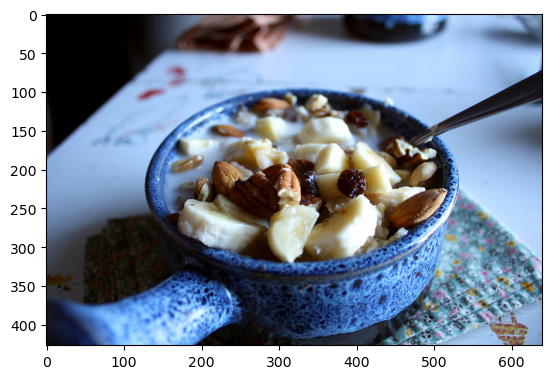

OutOfMemoryError: CUDA out of memory. Tried to allocate 102.00 MiB. GPU 

In [7]:
img = img_files[0]
image_path = args.data_path + img
raw_image = Image.open(image_path)
plt.imshow(raw_image)
plt.show()
raw_image = raw_image.convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0)
image = image.to(device)

qu = "Please describe this image in detail."
template = INSTRUCTION_TEMPLATE[args.model]
qu = template.replace("<question>", qu)


with torch.inference_mode():
    with torch.no_grad():
        out = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
        )
print("Original output:")
print(out[0])
print("\n")

with torch.inference_mode():
    with torch.no_grad():
        out1 = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
            output_attentions=True,
            opera_decoding=True,
            scale_factor=50,
            threshold=15.0,
            num_attn_candidates=5,
        )
print("OPERA's output:")
print(out1[0])

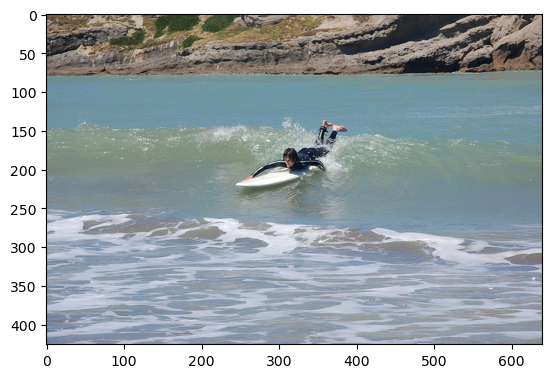

OutOfMemoryError: CUDA out of memory. Tried to allocate 102.00 MiB. GPU 

In [7]:
img = img_files[1]
image_path = args.data_path + img
raw_image = Image.open(image_path)
plt.imshow(raw_image)
plt.show()
raw_image = raw_image.convert("RGB")
image = vis_processors["eval"](raw_image).unsqueeze(0)
image = image.to(device)

qu = "Please describe this image in detail."
template = INSTRUCTION_TEMPLATE[args.model]
qu = template.replace("<question>", qu)


with torch.inference_mode():
    with torch.no_grad():
        out = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
        )
print("Original output:")
print(out[0])
print("\n")

with torch.inference_mode():
    with torch.no_grad():
        out1 = model.generate(
            {"image": norm(image), "prompt":qu}, 
            use_nucleus_sampling=False, 
            num_beams=5,
            max_new_tokens=512,
            output_attentions=True,
            opera_decoding=True,
            scale_factor=50,
            threshold=15.0,
            num_attn_candidates=5,
        )
print("OPERA's output:")
print(out1[0])